# CapeCod Onleveling

In [1]:
import chainladder as cl
import pandas as pd

This example demonstrates how to incorporate on-leveling into the `CapeCod`
estimator.  The on-level approach emulates the approach taken by Friedland in
"Estimating Unpaid Claims Using Basic Techniques" Chapter 10.  The `ParallelogramOLF`
estimator is new in chainladder 0.7.9 as is the ``xyz`` triangle.


In [2]:

# Grab a triangle
xyz = cl.load_sample('xyz')

# Premium on-leveling factors
rate_history = pd.DataFrame({
    'date': ['1/1/1999', '1/1/2000', '1/1/2001', '1/1/2002', '1/1/2003',
             '1/1/2004', '1/1/2005', '1/1/2006', '1/1/2007', '1/1/2008'],
    'rate_change': [.02, .02, .02, .02, .05, .075, .15, .1, -.2, -.2]
})

# Loss on-leveling factors
tort_reform = pd.DataFrame({
    'date': ['1/1/2006', '1/1/2007'],
    'rate_change': [-0.1067, -.25]
})

# In addition to development, include onlevel estimator in pipeline for loss
pipe = cl.Pipeline(steps=[
    ('olf', cl.ParallelogramOLF(tort_reform, change_col='rate_change', date_col='date', vertical_line=True)),
    ('dev', cl.Development(n_periods=2)),
    ('model', cl.CapeCod(trend=0.034))
])

# Define X
X = cl.load_sample('xyz')['Incurred']

# Separately apply on-level factors for premium
sample_weight = cl.ParallelogramOLF(
    rate_history, change_col='rate_change', date_col='date',
    vertical_line=True).fit_transform(xyz['Premium'].latest_diagonal)

#  Fit Cod Estimator
pipe.fit(X, sample_weight=sample_weight).named_steps.model.ultimate_

# Create a Cape Cod pipeline without onleveling
pipe2 = cl.Pipeline(steps=[
    ('dev', cl.Development(n_periods=2)),
    ('model', cl.CapeCod(trend=0.034))
])

# Finally fit Cod Estimator without on-leveling
pipe2.fit(X, sample_weight=xyz['Premium'].latest_diagonal).named_steps.model.ultimate_

# Plot results
results = cl.concat((
    pipe.named_steps.model.ultimate_.rename('columns', ['With On-level']),
    pipe2.named_steps.model.ultimate_.rename('columns', ['Without On-level'])), 1).T

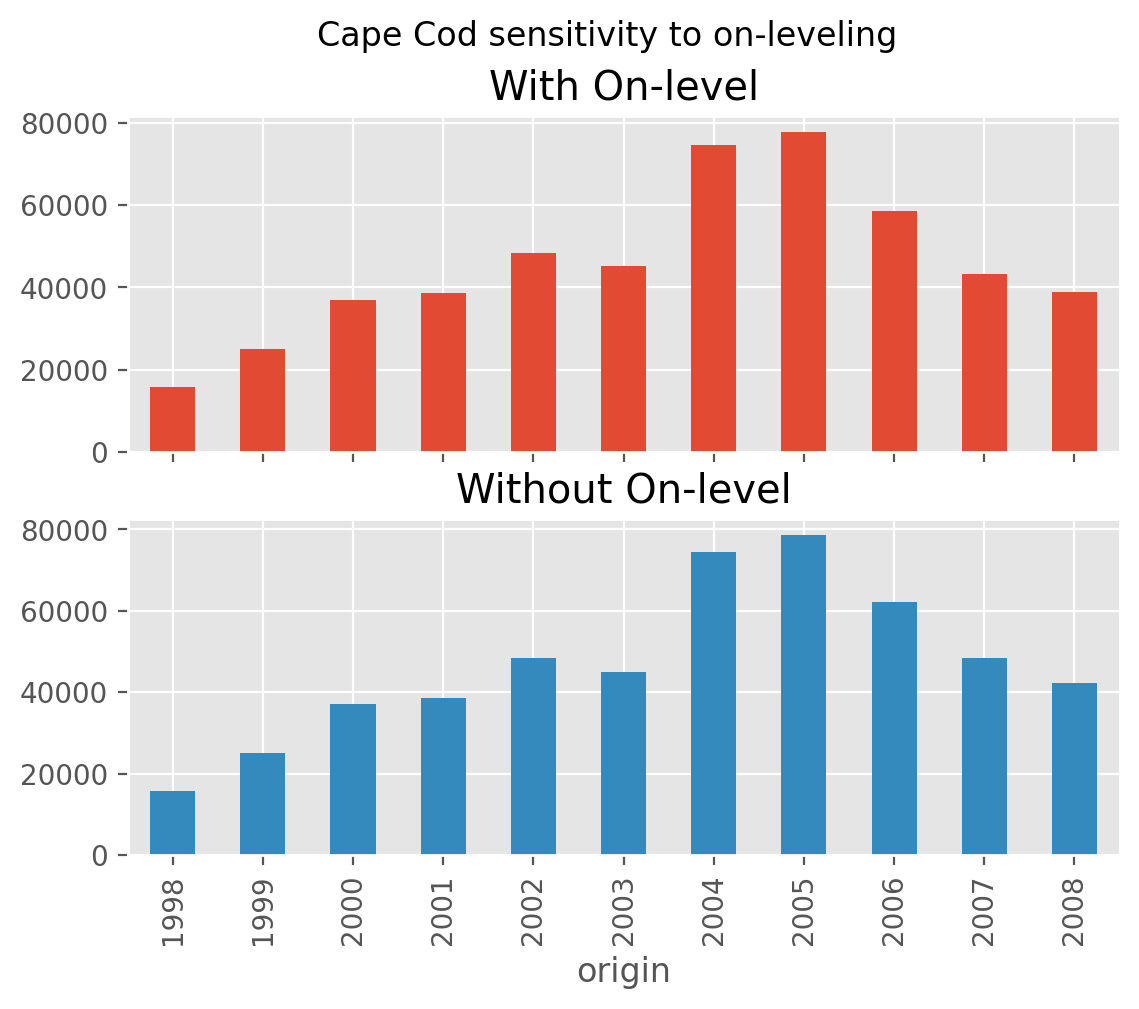

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

ax = results.plot(
    kind='bar', title='Cape Cod sensitivity to on-leveling', 
    subplots=True, legend=False);